# Continuous RL - DeepSARSA

In [1]:
import random
import numpy as np
import copy
import gym
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import AdamW
from tqdm import tqdm
from utils import plot_cost_to_go , plot_max_q , test_agent , plot_stats , seed_everything
%matplotlib notebook

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [2]:
env = gym.make('MountainCar-v0')
seed_everything(env)

C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\ProgramData\Anaconda3\envs\vrep\lib\site-packages\gym\core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:
state_dims = env.observation_space.shape[0]
num_actions = env.action_space.n
print(f"state dim: {state_dims}, action dim: {num_actions}")

state dim: 2, action dim: 3


In [4]:
class PreprocessEnv(gym.Wrapper):
    
    def __init__(self , env ):
        gym.Wrapper.__init__(self,env)
        
    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).unsqueeze(dim=0).float()
    
    def step(self , action):
        action = action.item()
        next_state , reward , done , info = self.env.step(action)
        next_state = torch.from_numpy(next_state).unsqueeze(dim=0).float()
        reward = torch.tensor(reward).view(1,-1).float()
        done = torch.tensor(done).view(1,-1)
        return next_state , reward , done , info
        

In [5]:
env = PreprocessEnv(env)

In [6]:
env.reset()

tensor([[-0.4452,  0.0000]])

In [7]:
action = torch.tensor(0)
env.step(action)

(tensor([[-0.4468, -0.0016]]), tensor([[-1.]]), tensor([[False]]), {})

In [8]:
# Q-Network
q_network = nn.Sequential(
    nn.Linear(state_dims , state_dims**7 ),
    nn.ReLU(),
    nn.Linear(state_dims**7 , state_dims**6 ),
    nn.ReLU(),
    nn.Linear(state_dims**6 , num_actions )
)
q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

In [9]:
# Target Q-Network
target_q_network = copy.deepcopy(q_network)
target_q_network = target_q_network.eval() # NN wont change its parameters
target_q_network

Sequential(
  (0): Linear(in_features=2, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)

In [10]:
# Experience Replay Memory
class ReplayMemory: # [St , At , Rt+1 , St+1]
    def __init__(self , capacity=1e6):
        self.capacity = capacity
        self.memory =[]
        self.position = 0
        
    def insert(self , transition):
        if len(self.memory)<self.capacity:
            self.memory.append(None)
        self.memory[self.position] = transition
        self.position = (self.position +1) #% self.capacity
        
    def sample(self , batch_size):
        assert self.can_sample(batch_size)
        batch = random.sample(self.memory , batch_size)
        
        batch = zip(*batch) # -> all the states together all the rewards together ,etc.
        
        return [ torch.cat(items) for items in batch] # size : batch_size X D 
        
        
    def can_sample(self , batch_size):
        return len(self.memory)>=batch_size*10
    
    def __len__(self):
        return len(self.memory)

In [11]:
def policy(state, epsilon=0.):    
    if torch.rand(1) < epsilon:
        return torch.randint(num_actions, (1, 1))
    else:
        av = q_network(state).detach()
        return torch.argmax(av, dim=-1, keepdim=True)

def deep_sarsa(q_network , policy , episodes , alpha = 1e-3 , batch_size=32 , gamma=0.99 , epsilon = 0.01):
    
    optim = AdamW(q_network.parameters() , lr = alpha)
    memory = ReplayMemory(capacity = 1e6)
    stats = { 'MSE Loss':[] , 'Returns': []  }
    
    for i in tqdm(range( 1 , episodes+1)):
        state = env.reset()
        done = False
        ep_return = 0
        
        while not done :
            action = policy(state , epsilon)
            next_state , reward , done , _ = env.step(action)
            memory.insert([state , action , reward , done , next_state])
            
            if memory.can_sample(batch_size):
                state_b , action_b , reward_b , done_b , next_state_b = memory.sample(batch_size)
                qsa_b = q_network(state_b).gather( 1 , action_b)
                next_action_b = policy(next_state_b , epsilon)
                next_qsa_b = target_q_network(next_state_b).gather(1 ,next_action_b )
                target_b = reward_b + (torch.logical_not(done_b))*gamma*next_qsa_b
                
                loss = F.mse_loss(qsa_b , target_b)
                q_network.zero_grad()
                loss.backward()
                optim.step()
                
                stats ['MSE Loss'].append(loss.item())
                
            state = next_state
            ep_return += reward.item()
        stats['Returns'].append(ep_return)
        
        if episodes % 10 ==0:
            target_q_network.load_state_dict(q_network.state_dict())
    return stats

In [12]:
stats = deep_sarsa ( q_network , policy , 2000)

100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [08:39<00:00,  3.85it/s]


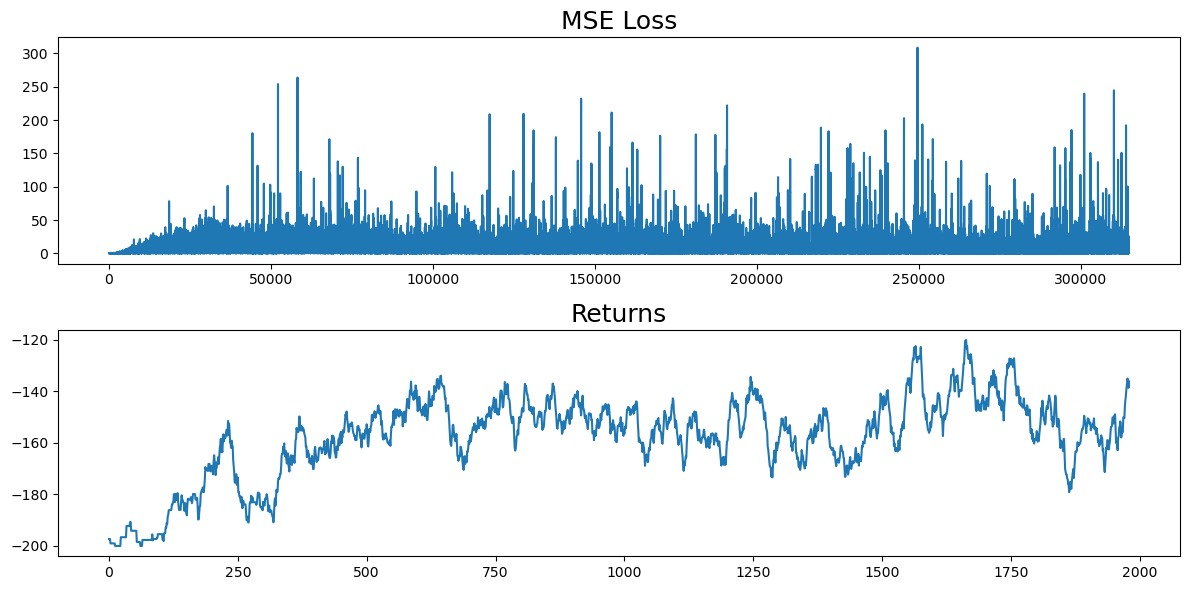

In [17]:
plot_stats(stats)

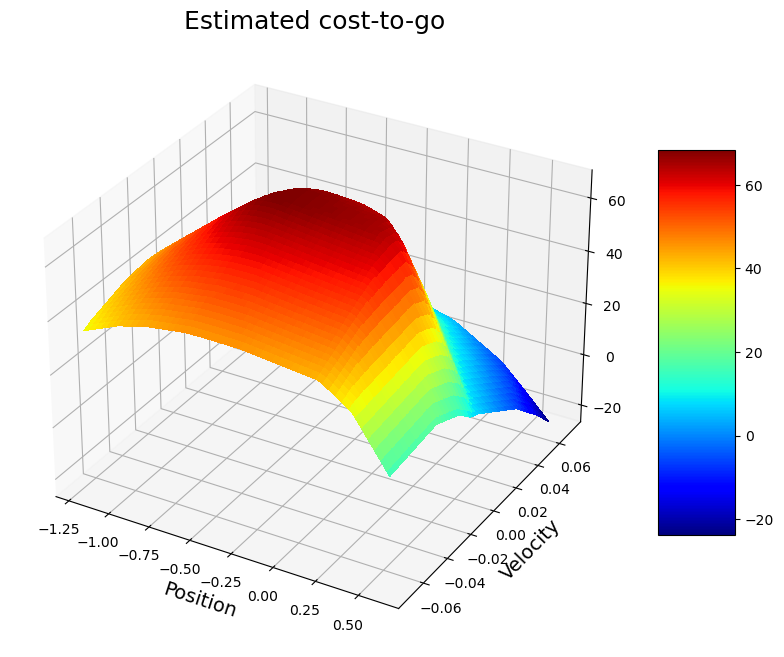

In [18]:
plot_cost_to_go(env , q_network , xlabel = 'Position' , ylabel = 'Velocity')

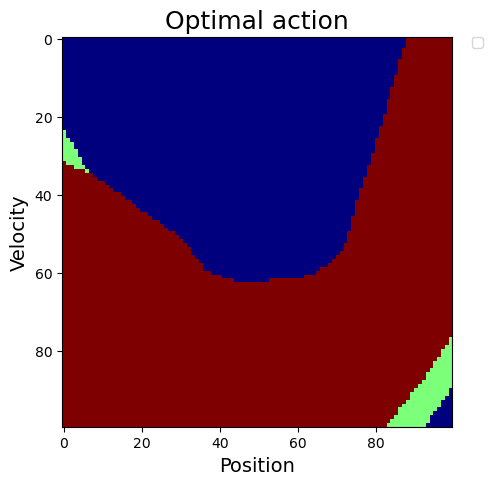

In [19]:
plot_max_q(env , q_network , xlabel = 'Position' , ylabel = 'Velocity')

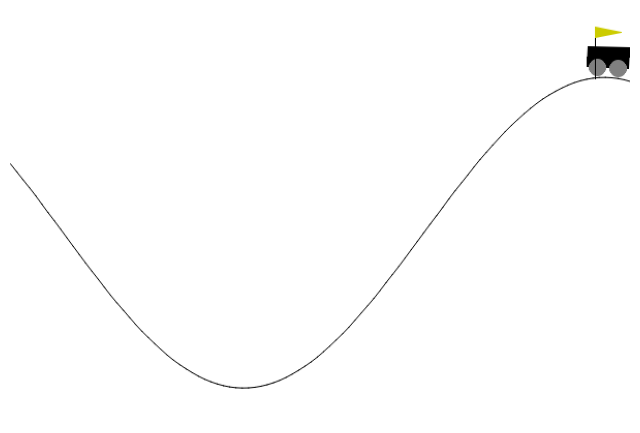

In [20]:
%matplotlib inline
test_agent(env , policy , 3)